# Lab 10: RNNs
# Chanapa Pananookooln | st121395

# PART I : Predicting the language a surname comes from (IN LAB)
The sequence we will input to the RNN is the sequence of the letters in the names.

The output is the language each name belongs to.

(https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

## Import the data from all the txt files

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path):
    return glob.glob(path)

print(findFiles('../../data/RNN/data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

['../../data/RNN/data/names/Arabic.txt', '../../data/RNN/data/names/Chinese.txt', '../../data/RNN/data/names/Czech.txt', '../../data/RNN/data/names/Dutch.txt', '../../data/RNN/data/names/English.txt', '../../data/RNN/data/names/French.txt', '../../data/RNN/data/names/German.txt', '../../data/RNN/data/names/Greek.txt', '../../data/RNN/data/names/Irish.txt', '../../data/RNN/data/names/Italian.txt', '../../data/RNN/data/names/Japanese.txt', '../../data/RNN/data/names/Korean.txt', '../../data/RNN/data/names/Polish.txt', '../../data/RNN/data/names/Portuguese.txt', '../../data/RNN/data/names/Russian.txt', '../../data/RNN/data/names/Scottish.txt', '../../data/RNN/data/names/Spanish.txt', '../../data/RNN/data/names/Vietnamese.txt']


## Convert the strings to plain ASCII

In [4]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

## Build dict category_lines

Each key is the language and the value is the list of all the name in that language

In [5]:
category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../../data/RNN/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

# number of languages in our dataset
n_categories = len(all_categories)

## Functions for Encoding all the letters in a name into One-hot tensors

In [6]:
import torch

# Find letter index from all_letters, e.g. "a" -> 0

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

## The RNN Structure

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined) # the hidden state is a concatenation of the input and the previous hidden state
        output = self.i2o(hidden) # changed the output to accept the hidden as input but no non-linearity yet
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

*Why don't the numbers add up to 1.0 if it's a softmax output?* : because it's LogSoftmax

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

## Functions for getting a random sample for training

In [1]:
import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

For the loss function, let's use negative log likelihood:

In [13]:
criterion = nn.NLLLoss() 

In [14]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()  

## Training: one name at a time

In [15]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  app.launch_new_instance()


5000 5% (0m 20s) 2.7444 Riagain / Greek ✗ (Irish)
10000 10% (0m 40s) 1.4190 Ryoo / Korean ✓
15000 15% (1m 1s) 1.3704 Messer / German ✓
20000 20% (1m 21s) 1.1470 Ta / Vietnamese ✓
25000 25% (1m 41s) 2.8102 Salazar / Arabic ✗ (Portuguese)
30000 30% (2m 0s) 1.9460 Wakelin / Russian ✗ (English)
35000 35% (2m 20s) 1.1848 Hattori / Italian ✗ (Japanese)
40000 40% (2m 39s) 0.1755 Fukunaka / Japanese ✓
45000 45% (2m 59s) 1.3923 Smith / Scottish ✓
50000 50% (3m 19s) 0.0888 Tochikura / Japanese ✓
55000 55% (3m 39s) 4.1937 Gallchobhar / Czech ✗ (Irish)
60000 60% (3m 59s) 0.0665 Dubanowski / Polish ✓
65000 65% (4m 18s) 0.7735 Murphy / Irish ✓
70000 70% (4m 38s) 0.2811 Morrison / Scottish ✓
75000 75% (4m 59s) 1.1953 Hinchin / Russian ✓
80000 80% (5m 19s) 0.1329 Jinkin / Russian ✓
85000 85% (5m 38s) 0.5508 Young / Scottish ✓
90000 90% (5m 59s) 0.6008 Baglio / Italian ✓
95000 95% (6m 18s) 0.6063 Trieu / Vietnamese ✓
100000 100% (6m 38s) 1.0697 Weineltk / Czech ✓


## Training Loss

 Finally, plot the resulting training loss:

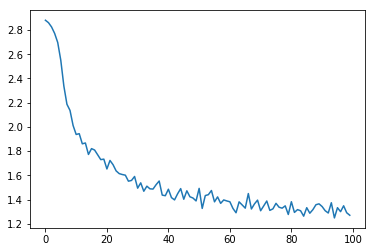

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluation
Get a confusion matrix:

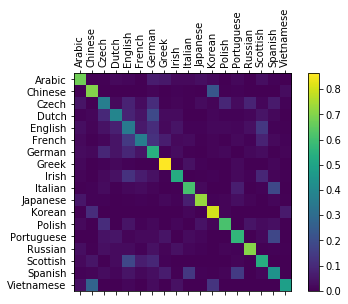

In [17]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## RESULTS

In this part we trained RNN where the hidden state is a combination of the input of the current state and the hidden state of the previous time step.

There is no non-linearity function between the hidden state to the output.

We used nn.NLLLoss() and softmax activation function at the end to output the most probable language of the name.

The model was trained for 100000 iters. From the loss plot we can see the the loss has decrease and it has converged quite well to the value at about 1.2.

We also evaluate the model with a confusion matrix. It can be seen from the diagonka line that the the model is predicting the languages of the name quite well. However, at other position there are some light color boxes which indicate where the model predict the languages incorrectly.